## Visualization of Cosegmentation Masks

In [1]:
import torch
import os, sys
sys.path.append('..')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# add path for models and other utils
sys.path += ['../../src/', '../../src/models/']

import data_manager
from video_loader import VideoDataset
import transforms as T
from torch.utils.data import DataLoader
from samplers import RandomIdentitySampler
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import utils
import models

In [143]:
class options():
    def __init__(self):
        self.root = '../../data/'
        self.dataset = 'mars'
        self.data_selection = 'random'
        self.height = 256
        self.width = 128
        self.use_cpu = False
        self.num_instances = 4
        self.train_batch = 1
        self.test_batch = 1
        self.workers = 0
        self.seq_len = 4
        self.pretrained_model = '../../src/models/pretrained/mars_se_resnet50_tp_cosam45_ep800_02.pth.tar'
        
args = options()

In [145]:
dataset = data_manager.init_dataset(name=args.dataset, root=args.root)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

use_gpu = not args.use_cpu
pin_memory = True if use_gpu else False

dataloader = DataLoader(
    VideoDataset(dataset.query, seq_len=args.seq_len,
                 sample='dense', transform=transform),
    batch_size=args.test_batch, shuffle=False, num_workers=args.workers,
    pin_memory=pin_memory, drop_last=False,
)


=> MARS loaded
Dataset statistics:
  ------------------------------
  subset   | # ids | # tracklets
  ------------------------------
  train    |   625 |     8298
  query    |   626 |     1980
  gallery  |   622 |     9330
  ------------------------------
  total    |  1251 |    19608
  number of images per tracklet: 2 ~ 920, average 59.5
  ------------------------------


In [146]:
model = models.init_model(name='se_resnet50_cosam45_tp', num_classes=dataset.num_train_pids, loss={'xent', 'htri'}).cuda()

# pretrained model loading
if args.pretrained_model is not None:
    model = utils.load_pretrained_model(model, args.pretrained_model)

instantiating SE_ResNet net typesenet50 from ../../src/models/SE_ResNet.py
attention type ['NONE', 'NONE', 'NONE', 'COSAM', 'COSAM']
Initialized model with pretrained weights from http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth
setting stride of  Sequential(
  (0): SEResNetBottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (se_module): SEModule(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Conv2d(2048, 128, kernel_size=(1, 1), stride=(1, 1

In [147]:
data_iterator = iter(dataloader)

def sample_data_and_display():
    data = data_iterator.next()
    data[0] = (data[0] - torch.min(data[0])) / (torch.max(data[0]) - torch.min(data[0]))
    sampled_images = data[0].squeeze()[0]
    print(sampled_images.shape)
    grid = make_grid(sampled_images).permute(1,2,0)
    plt.imshow(grid.data.cpu().numpy())
    plt.axis('off')
    plt.show()
    return sampled_images

In [148]:
def get_features(data):
    model.eval()
    with torch.no_grad():
        features, attentions = model(data[None,:].cuda(), return_attentions=True)
    
    return features, attentions

In [149]:
def normalize_masks(tensor, dim=2):
    min_ = torch.min(tensor, dim=dim, keepdim=True)[0].expand_as(tensor)
    max_ = torch.max(tensor, dim=dim, keepdim=True)[0].expand_as(tensor)
    return (tensor - min_) / (max_ - min_)

In [150]:
def perform_run():
    data = sample_data_and_display()
    features, attentions = get_features(data)
    
    for i, attention in enumerate(attentions):
        if attention[3] is None:
            continue
            
        orig_maps = F.interpolate(attention[3], size=data.shape[2:], mode='bilinear')
        norm_maps = normalize_masks(orig_maps.view(orig_maps.shape[0], orig_maps.shape[1], -1)).view_as(orig_maps)

        norm_imgs = make_grid(norm_maps.cpu())
        norm_masks = norm_imgs.permute((1,2,0)).mean(dim=2)
        #print(norm_masks.min(), norm_masks.max(), (norm_masks>=0.5).sum())

        plt.figure()
        plt.imshow(norm_masks.numpy(), cmap='jet')
        plt.axis('off')        
#         plt.colorbar()
        plt.show()

torch.Size([4, 3, 256, 128])


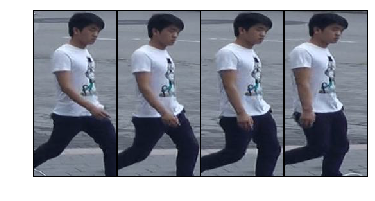

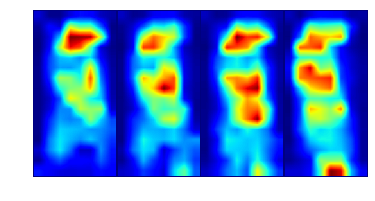

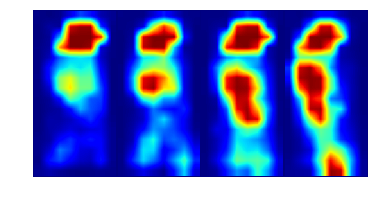

In [373]:
perform_run()